In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import casadi as ca
import casadi.tools as ct
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0

In [37]:
n_y = 1
measured_state = 1 # if x1 -> 0, if x2 -> 1
use_test_set = True
import pickle as pkl
with open('data/test_set_prbs.pkl', 'rb') as f:
    test_set = pkl.load(f)
u_test = test_set['u_test']
x_n_test = test_set['x_n_test']
x_test = test_set['x_test']
y_test = test_set['y_test']
data_test = test_set['data_test']

In [38]:
data_test[1]

{'a': 0.5793549286293024,
 'b': 0.29252235469645455,
 'c': 45.18246674569545,
 'd': 0.42562733008247805,
 'e': 58.706503838246505,
 'f': 0.17284017869498816,
 'g': 102.26796069438008,
 'h': 0.14292508623717876,
 'M': 16.818559645397748,
 'C': 4.5186701658088495,
 'UA2': 7.985757910065125,
 'Cp': 0.07741157058590424,
 'lam': 42.281652454767716,
 'lams': 38.77617350473942,
 'F1': 11.532133253889011,
 'X1': 5.998173213875621,
 'F3': 43.963220108856206,
 'T1': 38.014749102575124,
 'T200': 22.92693984015558,
 'T2': 82.23653155940286,
 'T3': 79.57367704092954,
 'T100': 131.94686629863259,
 'UA1': 7.931678165133069,
 'Q100': 394.28637663260423,
 'F100': 10.168264194103953,
 'Q200': 358.07998564832866,
 'F5': 8.468921266296233,
 'F4': 8.391551942554171,
 'F2': 3.1405813113348398}

In [39]:
def problem_data():
    """ Problem data, numeric constants,...
    """
    data = {}
    data['a'] = 0.5616
    data['b'] = 0.3126
    data['c'] = 48.43
    data['d'] = 0.507
    data['e'] = 55.0
    data['f'] = 0.1538
    data['g'] = 90.0
    data['h'] = 0.16
    data['M'] = 20.0
    data['C'] = 4.0
    data['UA2'] = 6.84
    data['Cp'] = 0.07
    data['lam'] = 38.5
    data['lams'] = 36.6
    data['F1'] = 10.0
    data['X1'] = 5.0
    data['F3'] = 50.0
    data['T1'] = 40.0
    data['T200'] = 25.0
    return data

def opti_data(opti):
    """ Problem data, numeric constants,...
    """
    # data = {}
    # 
    # data['a'] = 0.5616
    # data['b'] = 0.3126
    # data['c'] = 48.43
    # data['d'] = 0.507
    # data['e'] = 55.0
    # data['f'] = 0.1538
    # data['g'] = 90.0
    # data['h'] = 0.16
    # data['M'] = 20.0
    # data['C'] = 4.0
    # data['UA2'] = opti.variable()
    # data['Cp'] = 0.07
    # data['lam'] = 38.5
    # data['lams'] = 36.6
    # data['F1'] = 10.0
    # data['X1'] = 5.0
    # data['F3'] = 50.0
    # data['T1'] = 40.0
    # data['T200'] = 25.0
    
    data = data_test[0]
    data['UA2'] = opti.variable()

    return data

def intermediate_vars(x, u, data):

    """ Intermediate model variables
    """

    data['T2'] = data['a']*x['P2'] + data['b']*x['X2'] + data['c']
    data['T3'] = data['d']*x['P2'] + data['e']
    data['T100'] = data['f']*u['P100'] + data['g'] # added noise
    data['UA1'] = data['h']*(data['F1']+data['F3'])
    data['Q100'] = data['UA1']*(data['T100'] - data['T2'])
    data['F100'] = data['Q100']/data['lams']
    data['Q200'] = data['UA2']*(data['T3']-data['T200'])/(1.0 + data['UA2']/(2.0*data['Cp']*u['F200']))
    data['F5'] = data['Q200']/data['lam']
    data['F4'] = (data['Q100']-data['F1']*data['Cp']*(data['T2']-data['T1']))/data['lam']
    data['F2'] = (data['F1'] - data['F4'])
    return data

In [40]:
def dynamics(x, u, data):
    """ System dynamics function (discrete time)
    """
    # state derivative expression
    xdot = ca.vertcat(
        (data['F1']*data['X1'] - data['F2']*x['X2'])/data['M'],
        (data['F4'] - data['F5'])/data['C']
        )

    # create ode for integrator
    ode = {'x':x,
           'p':ca.vertcat(u,
                          data['UA2']), 
           'ode': xdot}

    return [ca.integrator('F','collocation',ode,{'tf':1}), ode]

def vars():

    """ System states and controls
    """

    x = ct.struct_symMX(['X2','P2'])
    u = ct.struct_symMX(['P100','F200'])

    return x, u

In [41]:
# set-up system
x, u = vars()
#data = intermediate_vars(x, u, problem_data())
opti = ca.Opti()
data = intermediate_vars(x, u, opti_data(opti))
f = dynamics(x, u, data)[0]

In [42]:
res = f(x0=x, p=ca.vertcat(u,
                          data['UA2']))

x_next = res['xf'] # Access x_next as the DAE symbolic solution
# Define function F to simplify mapping between symbolic (x,u) --> (x_next)
F = ca.Function('F',[x, ca.vertcat(u,
                          data['UA2'])],[x_next],['x','u'],['x_next'])

In [43]:
# Simulation parameters
T = 500
Ts = 1

x_s = x_n_test[1,0,:]#[25.0, 49.743]
u_s = u_test[1,0,:]#u0[]#[191.713, 215.888]

X_log = []
#X_log = np.empty((2,0))
#U_log = np.empty((2,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

obj = 0

for i in range(T):
    # print(i)
    s = x_0
    #a = u_0
    
    s_next = F(s, ca.vertcat(u_0,
                          data['UA2']))
    
    obj += ca.sumsqr(x_0 - x_n_test[1,i,:])

    x_0 = s_next#np.array(s_next).flatten()

    
    #print(x_0)
    #X_log.append(x_0)
    #U_log = np.column_stack((U_log, a[:2]))
    #X_log = np.column_stack((X_log, x_0))

# plt.subplot(211)    
# plt.plot(X_log[0,:], label="$x_1$")
# plt.plot(X_log[1,:], label="$x_2$")
# plt.legend()
# plt.grid()
# 
# plt.subplot(212)    
# plt.plot(U_log[0,:], label="$u_1$")
# plt.plot(U_log[1,:], label="$u_2$")
# plt.legend()
# plt.grid()
# 
# plt.tight_layout()

In [44]:
opti.minimize(obj)

opts = dict()
opts["ipopt.print_level"] = 1
opts["print_time"] = False
opti.solver('ipopt',opts)

# opti.set_initial(data['a'], 0.5616)
# opti.set_initial(data['b'], 0.3126)
# opti.set_initial(data['c'], 48.43)
# opti.set_initial(data['d'], 0.507)
# opti.set_initial(data['e'], 55.0)
# opti.set_initial(data['f'], 0.1538)
# opti.set_initial(data['g'], 90.0)
# opti.set_initial(data['h'], 0.16)
# opti.set_initial(data['M'], 20.0)
# opti.set_initial(data['C'], 4.0)
opti.set_initial(data['UA2'], 6.84)
# opti.set_initial(data['Cp'], 0.07)
# opti.set_initial(data['lam'], 38.5)
# opti.set_initial(data['lams'], 36.6)
# opti.set_initial(data['F1'], 10.0)
# opti.set_initial(data['X1'], 5.0)
# opti.set_initial(data['F3'], 50.0)
# opti.set_initial(data['T1'], 40.0)
# opti.set_initial(data['T200'], 25.0)

# Test over 1 time horizon
sol = opti.solve()

In [45]:
sol.value(data['UA2'])

4.803555302358455

In [130]:
T = 300
Ts = 1
N = 10 
x_s = [25.0, 49.743]
u_s = [191.713, 215.888]
# Test steady state validity
print(F(x_s, u_s))
x = ca.MX.sym('x')
u = ca.MX.sym('u')

[25, 49.743]


[17.92, 49.9811]
[13.6737, 50.3235]
[11.026, 50.7224]
[9.3333, 51.1504]
[8.23203, 51.5906]
[7.50509, 52.0331]
[7.01836, 52.4716]
[6.68712, 52.9021]
[6.45711, 53.3225]
[6.29334, 53.7313]
[6.17311, 54.128]
[6.08169, 54.5122]
[6.0095, 54.8838]
[5.9503, 55.2432]
[5.90004, 55.5903]
[5.85607, 55.9257]
[5.81666, 56.2495]
[5.78067, 56.5622]
[5.74734, 56.864]
[5.71618, 57.1554]
[5.68682, 57.4367]
[5.65904, 57.7081]
[5.63264, 57.9702]
[5.60751, 58.223]
[5.58353, 58.4671]
[5.56064, 58.7027]
[5.53875, 58.93]
[5.51781, 59.1494]
[5.49777, 59.3611]
[5.47857, 59.5654]
[5.46019, 59.7625]
[5.44257, 59.9528]
[5.42568, 60.1364]
[5.40948, 60.3136]
[5.39395, 60.4845]
[5.37904, 60.6495]
[5.36475, 60.8087]
[5.35102, 60.9623]
[5.33785, 61.1105]
[5.3252, 61.2536]
[5.31306, 61.3916]
[5.3014, 61.5247]
[5.29019, 61.6532]
[5.27943, 61.7772]
[5.26908, 61.8968]
[5.25914, 62.0122]
[5.24959, 62.1236]
[5.2404, 62.231]
[5.23157, 62.3347]
[5.22308, 62.4347]
[5.21492, 62.5312]
[5.20706, 62.6243]
[5.19951, 62.7142]
[5.19224

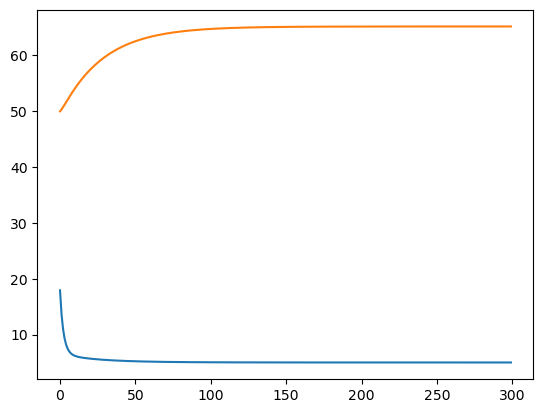

In [131]:
X_log = np.empty((2,0))
U_log = np.empty((2,0))

x_0 = np.array(x_s)
u_0 = np.array(u_s)

for i in range(300):
    # print(i)
    s = x_0
    a = [0.01, 0.01]
    
    s_next = F(s, a)
    
    print(s_next)

    x_0 = np.array(s_next).flatten()

    U_log = np.column_stack((U_log, a[:2]))
    X_log = np.column_stack((X_log, x_0))
    
plt.plot(X_log[0,:])
plt.plot(X_log[1,:])